# Advertisement Detection using Audio Matching

Find all instances of an audio advertisements in an longer audio clip.

This is an answer for a [question on Stack Overflow](https://stackoverflow.com/questions/75961430/how-to-find-out-how-many-times-a-specific-audio-repeats-in-another-longer-audio?noredirect=1#comment133991665_75961430).

The detection is done using an *audio matching* technique, called [DiagonalMatching](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C7/C7S2_DiagonalMatching.html) from the book [Fundamentals of Music Processing
Using Python and Jupyter Notebooks](https://www.audiolabs-erlangen.de/fau/professor/mueller/bookFMP) (FMP) by Meinard Müller.

Some functions are reused from there.
There are also some differences. In particular, the feature representation is different. As the FMP example has a feature-set that is specific to music.

NOTE: This approach assumes that the audio clip being queried for is very similar each time it appears.
If there is variations in the clip or it or occurs together with other sounds et.c, it will probably not work well.

The operating principle is Euclidean distance in the feature space. Matches should then have a very low distance, compared to other audio. 
This is conceptually similar to cross-correlation.


In [5]:
import math

import numpy
import pandas
import librosa

np = numpy # code from FMP uses this

In [6]:
time_resolution = 0.500
samplerate = 16000

def next_power_of_2(x):
    return 2**(math.ceil(math.log(x, 2)))

hop_length = int(time_resolution*samplerate)
n_mfcc

In [ ]:

def load_audio_features(path, sr, **kwargs)
    audio, sr = librosa.load(sr=sr, mono=True):

    f = compute_features(audio, sr=sr, **kwargs)
    return f
        

In [10]:
audio, sr = librosa.load('house_ad.m4a', sr=samplerate)
long, sr = librosa.load('long_audio.m4a', sr=samplerate)


/tmp/ipykernel_88917/26545440.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load('house_ad.m4a', sr=samplerate)
/home/jon/.local/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_88917/26545440.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  long, sr = librosa.load('long_audio.m4a', sr=samplerate)
/home/jon/.local/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [28]:
def normalize_feature_sequence(X, norm='2', threshold=0.0001, v=None):
    """Normalizes the columns of a feature sequence

    Notebook: C3/C3S1_FeatureNormalization.ipynb

    Args:
        X (np.ndarray): Feature sequence
        norm (str): The norm to be applied. '1', '2', 'max' or 'z' (Default value = '2')
        threshold (float): An threshold below which the vector ``v`` used instead of normalization
            (Default value = 0.0001)
        v (float): Used instead of normalization below ``threshold``. If None, uses unit vector for given norm
            (Default value = None)

    Returns:
        X_norm (np.ndarray): Normalized feature sequence
    """
    assert norm in ['1', '2', 'max', 'z']

    K, N = X.shape
    X_norm = np.zeros((K, N))

    if norm == '1':
        if v is None:
            v = np.ones(K, dtype=np.float64) / K
        for n in range(N):
            s = np.sum(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    if norm == '2':
        if v is None:
            v = np.ones(K, dtype=np.float64) / np.sqrt(K)
        for n in range(N):
            s = np.sqrt(np.sum(X[:, n] ** 2))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    if norm == 'max':
        if v is None:
            v = np.ones(K, dtype=np.float64)
        for n in range(N):
            s = np.max(np.abs(X[:, n]))
            if s > threshold:
                X_norm[:, n] = X[:, n] / s
            else:
                X_norm[:, n] = v

    if norm == 'z':
        if v is None:
            v = np.zeros(K, dtype=np.float64)
        for n in range(N):
            mu = np.sum(X[:, n]) / K
            sigma = np.sqrt(np.sum((X[:, n] - mu) ** 2) / (K - 1))
            if sigma > threshold:
                X_norm[:, n] = (X[:, n] - mu) / sigma
            else:
                X_norm[:, n] = v

    return X_norm

def compute_features(audio, sr, hop_length=512, n_mfcc=13, n_fft=None):
    
    if n_fft is None:
        n_fft = next_power_of_2(hop_length)
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc)
    mfcc = normalize_feature_sequence(mfcc)
    
    return mfcc

# TODO: implement normalization
query = compute_features(audio, sr=sr, hop_length=hop_length)
clip = compute_features(long, sr=sr, hop_length=hop_length)
query.shape, clip.shape

((13, 59), (13, 6577))

In [29]:

def cost_matrix_dot(X, Y):
    """Computes cost matrix via dot product

    Notebook: C7/C7S2_DiagonalMatching.ipynb

    Args:
        X (np.ndarray): First sequence (K x N matrix)
        Y (np.ndarray): Second sequence (K x M matrix)

    Returns:
        C (np.ndarray): Cost matrix
    """
    return 1 - np.dot(X.T, Y)

def matching_function_diag(C, cyclic=False):
    """Computes diagonal matching function

    Notebook: C7/C7S2_DiagonalMatching.ipynb

    Args:
        C (np.ndarray): Cost matrix
        cyclic (bool): If "True" then matching is done cyclically (Default value = False)

    Returns:
        Delta (np.ndarray): Matching function
    """
    N, M = C.shape
    assert N <= M, "N <= M is required"
    Delta = C[0, :]
    for n in range(1, N):
        Delta = Delta + np.roll(C[n, :], -n)
    Delta = Delta / N
    if cyclic is False:
        Delta[M-N+1:M] = np.inf
    return Delta

def mininma_from_matching_function(Delta, rho=2, tau=0.2, num=None):
    """Derives local minima positions of matching function in an iterative fashion

    Notebook: C7/C7S2_DiagonalMatching.ipynb

    Args:
        Delta (np.ndarray): Matching function
        rho (int): Parameter to exclude neighborhood of a matching position for subsequent matches (Default value = 2)
        tau (float): Threshold for maximum Delta value allowed for matches (Default value = 0.2)
        num (int): Maximum number of matches (Default value = None)

    Returns:
        pos (np.ndarray): Array of local minima
    """
    Delta_tmp = Delta.copy()
    M = len(Delta)
    pos = []
    num_pos = 0
    rho = int(rho)
    if num is None:
        num = M
    while num_pos < num and np.sum(Delta_tmp < tau) > 0:
        m = np.argmin(Delta_tmp)
        pos.append(m)
        num_pos += 1
        Delta_tmp[max(0, m - rho):min(m + rho, M)] = np.inf
    pos = np.array(pos).astype(int)
    return pos

def matches_diag(pos, Delta_N):
    """Derives matches from positions in the case of diagonal matching

    Notebook: C7/C7S2_DiagonalMatching.ipynb

    Args:
        pos (np.ndarray or list): Starting positions of matches
        Delta_N (int or np.ndarray or list): Length of match (a single number or a list of same length as Delta)

    Returns:
        matches (np.ndarray): Array containing matches (start, end)
    """
    matches = np.zeros((len(pos), 2)).astype(int)
    for k in range(len(pos)):
        s = pos[k]
        matches[k, 0] = s
        if isinstance(Delta_N, int):
            matches[k, 1] = s + Delta_N - 1
        else:
            matches[k, 1] = s + Delta_N[s] - 1
    return matches

# Compute cost matrix and matching function
C = cost_matrix_dot(query, clip)
Delta = matching_function_diag(C)


In [30]:
C.shape

(59, 6577)

In [31]:
Delta.shape

(6577,)

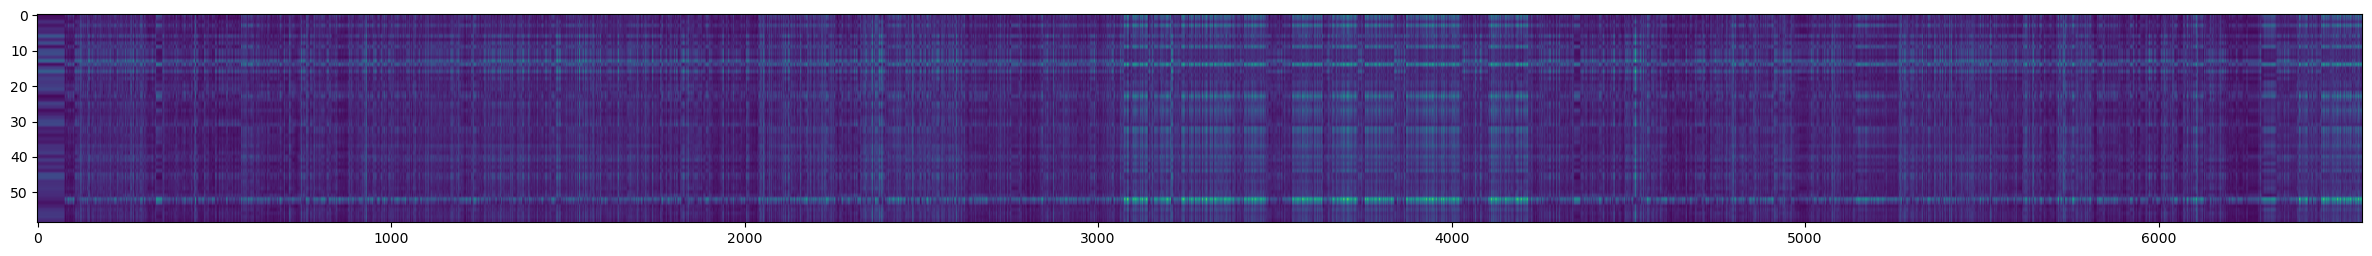

In [32]:
fig, ax = plt.subplots(1, figsize=(30, 5))

ax.imshow(C, aspect=10)

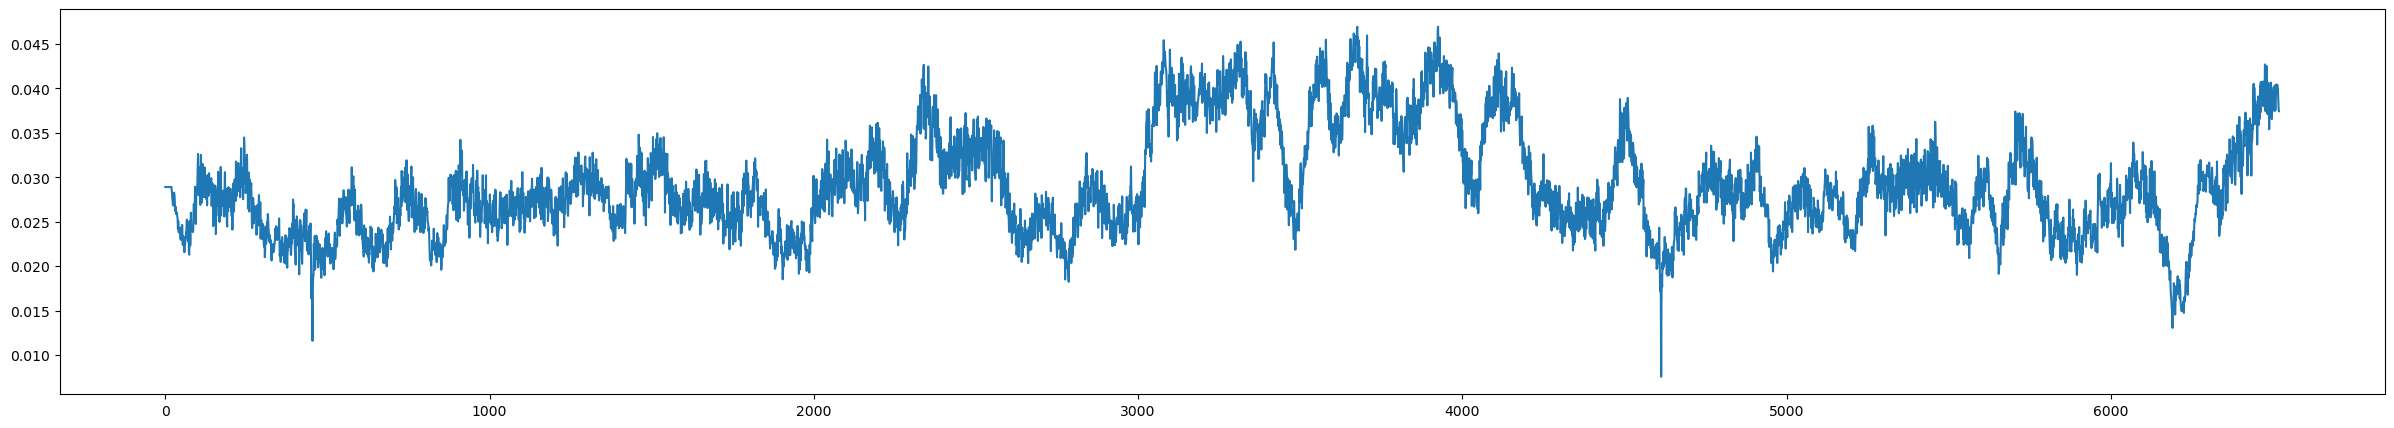

In [33]:
import seaborn
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, figsize=(30, 5))
ax.plot(Delta)
#seaborn.lineplot(y=Delta)